In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scqubits
from functools import partial
import qutip
import concurrent
from loky import get_reusable_executor
import numpy as np
import qutip
import scqubits
from typing import List, Union,Any

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ

In [2]:
EJ = 4
EC = EJ / 2.7
EL = EJ / 45

qbt = gfIFQ(EJ=EJ, EC=EC, EL=EL,truncated_dim=10)
tlist = np.linspace(0, int(1e4), 1000)

In [3]:


T1_results_data = {}
for temp_in_mK in [10, 20, 30, 40, 50]:
    loss_tangent_ref = 5e-6
    one_over_f_flux_noise_amplitude = 1e-6

    result = qutip.mesolve(
        rho0=qutip.basis(qbt.truncated_dim, 2),
        H=qbt.diag_hamiltonian,
        tlist=tlist,
        c_ops=qbt.get_T1_c_ops(
            temp_in_mK,
            loss_tangent_ref,
            one_over_f_flux_noise_amplitude
        ),
        e_ops=[qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(5)],
        args=None,
        options=qutip.Options(store_states=True, nsteps=1200000, num_cpus=1),
        progress_bar=qutip.ui.progressbar.EnhancedTextProgressBar(),
    )

    Tphi_c_ops = qbt.get_Tphi_c_ops(
        one_over_f_flux_noise_amplitude=one_over_f_flux_noise_amplitude
    )

    gamma_phi = np.abs(Tphi_c_ops.full().diagonal()[2])

    # Store results and other parameters for this run
    T1_results_data[temp_in_mK] = {
        "result": result,
        "gamma_phi": gamma_phi,
    }


 [          2%           ] Elapsed 0.19s / Remaining 00:00:00:09

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

 Total run time:   9.46s*] Elapsed 9.46s / Remaining 00:00:00:00
 [          1%           ] Elapsed 0.18s / Remaining 00:00:00:18

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 87

 Total run time:   9.56s*] Elapsed 9.56s / Remaining 00:00:00:00
 Total run time:   8.73s*] Elapsed 8.73s / Remaining 00:00:00:00
 Total run time:   9.44s*] Elapsed 9.44s / Remaining 00:00:00:00
 Total run time:  34.02s*] Elapsed 34.02s / Remaining 00:00:00:00


In [4]:
Tphi_results_data = {}
temp_in_mK = 20
loss_tangent_ref = 5e-6

result = qutip.mesolve(
    rho0=qutip.basis(qbt.truncated_dim, 2),
    H=qbt.diag_hamiltonian,
    tlist=tlist,
    c_ops=qbt.get_T1_c_ops(
        temp_in_mK,
        loss_tangent_ref,
        one_over_f_flux_noise_amplitude
    ),
    e_ops=[qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(5)],
    args=None,
    options=qutip.Options(store_states=True, nsteps=1200000, num_cpus=1),
    progress_bar=qutip.ui.progressbar.EnhancedTextProgressBar(),
)
for one_over_f_flux_noise_amplitude in [1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5]:
    Tphi_c_ops = qbt.get_Tphi_c_ops(
        one_over_f_flux_noise_amplitude=one_over_f_flux_noise_amplitude
    )
    gamma_phi = np.abs(Tphi_c_ops.full().diagonal()[2])
    # Store results and other parameters for this run
    Tphi_results_data[one_over_f_flux_noise_amplitude] = {
        "gamma_phi": gamma_phi,
    }

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 Total run time:   9.52s*] Elapsed 9.52s / Remaining 00:00:00:00


 /tmp/ipykernel_18230/3867729740.py: 16

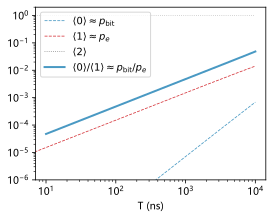

In [10]:
fig  = plt.figure(figsize=(4, 3)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0.15, right=0.95,bottom=0.17,top = 0.97)
# gs1 = fig.add_gridspec(nrows=1, ncols=1,left=0.6, right=0.85,bottom=0.15,top = 0.97)
ax = fig.add_subplot(gs0[0])

for (temp_in_mK, data), alpha in zip(T1_results_data.items(),[1, 0.7, 0.6, 0.4, 0.2]):
    result = data["result"]
    gamma_phi = data["gamma_phi"]
    
    ax.plot(tlist, result.expect[0], label=rf"$\langle{{0}}\rangle$",
            linestyle='--', lw=0.8, color='#4999c3', alpha=alpha)
    ax.plot(tlist, result.expect[1], label=rf"$\langle{{1}}\rangle = p_e$",
            linestyle='--', lw=0.8, color='#d5373d', alpha=alpha)
    ax.plot(tlist, result.expect[2], label=rf"$\langle{{2}}\rangle$",
            linestyle=':', lw=0.8, color='grey', alpha=0.5)
    ax.plot(tlist, result.expect[0] / result.expect[1], label=rf"$\langle{{0}}\rangle/\langle{{1}}\rangle = p_X/p_e$",
            linestyle='-', lw=2, color='#4999c3', alpha=alpha)
    break


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-6, 2)
ax.set_xlabel(r'T (ns)')

ax.legend(handles=[
    plt.Line2D([0], [0], linestyle='--', lw=0.8, color='#4999c3', label=rf"$\langle{{0}}\rangle \approx p_\text{{bit}}$"),
    plt.Line2D([0], [0], linestyle='--', lw=0.8, color='#d5373d', label=rf"$\langle{{1}}\rangle \approx p_e$"),
    plt.Line2D([0], [0], linestyle=':', lw=0.8, color='grey', label=rf"$\langle{{2}}\rangle$"),
    plt.Line2D([0], [0], linestyle='-', lw=2, color='#4999c3',label=rf"$\langle{{0}}\rangle/\langle{{1}}\rangle \approx p_\text{{bit}}/p_e$"),

], loc='upper left',prop={'size': 10})
fig.savefig('gf_mesolve_simple.pdf')

 /tmp/ipykernel_6238/3824693605.py: 16RuntimeWarning: invalid value encountered in divide
 /tmp/ipykernel_6238/3824693605.py: 24

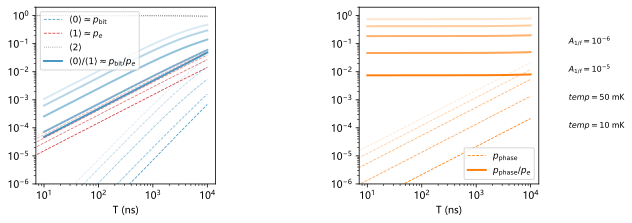

In [67]:
fig = plt.figure(figsize=(10, 3)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0.15, right=0.4,bottom=0.15,top = 0.97)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=0.6, right=0.85,bottom=0.15,top = 0.97)
axes = [fig.add_subplot(gs0[0]), fig.add_subplot(gs1[0])]

for (temp_in_mK, data), alpha in zip(T1_results_data.items(),[1, 0.7, 0.6, 0.4, 0.2]):
    result = data["result"]
    gamma_phi = data["gamma_phi"]
    
    axes[0].plot(tlist, result.expect[0], label=rf"$\langle{{0}}\rangle$",
            linestyle='--', lw=0.8, color='#4999c3', alpha=alpha)
    axes[0].plot(tlist, result.expect[1], label=rf"$\langle{{1}}\rangle = p_e$",
            linestyle='--', lw=0.8, color='#d5373d', alpha=alpha)
    axes[0].plot(tlist, result.expect[2], label=rf"$\langle{{2}}\rangle$",
            linestyle=':', lw=0.8, color='grey', alpha=0.5)
    axes[0].plot(tlist, result.expect[0] / result.expect[1], label=rf"$\langle{{0}}\rangle/\langle{{1}}\rangle = p_X/p_e$",
            linestyle='-', lw=2, color='#4999c3', alpha=alpha)
    break

for (one_over_f_flux_noise_amplitude, data), alpha in zip(Tphi_results_data.items(),[1, 0.7, 0.6, 0.4, 0.2]):
    result = T1_results_data[20]["result"]
    gamma_phi = data["gamma_phi"]
    axes[1].plot(tlist, 1 - np.exp(-gamma_phi * tlist), label=rf"$p_\phi$",
            linestyle='--', lw=0.8, color='#ff7f0e', alpha=alpha)
    axes[1].plot(tlist, (1 - np.exp(-gamma_phi * tlist)) / result.expect[1], label=rf"$ p_\phi/p_e$",
            linestyle='-', lw=2, color='#ff7f0e', alpha=alpha)
    break

for ax in axes:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(1e-6, 2)
        ax.set_xlabel(r'T (ns)')

axes[0].legend(handles=[
    plt.Line2D([0], [0], linestyle='--', lw=0.8, color='#4999c3', label=rf"$\langle{{0}}\rangle \approx p_\text{{bit}}$"),
    plt.Line2D([0], [0], linestyle='--', lw=0.8, color='#d5373d', label=rf"$\langle{{1}}\rangle \approx p_e$"),
    plt.Line2D([0], [0], linestyle=':', lw=0.8, color='grey', label=rf"$\langle{{2}}\rangle$"),
    plt.Line2D([0], [0], linestyle='-', lw=2, color='#4999c3',label=rf"$\langle{{0}}\rangle/\langle{{1}}\rangle \approx p_\text{{bit}}/p_e$"),

], loc='upper left',prop={'size': 9})

axes[1].legend(handles=[
    plt.Line2D([0], [0], linestyle='--', lw=0.8, color='#ff7f0e', label=rf"$p_\text{{phase}}$"),
    plt.Line2D([0], [0], linestyle='-', lw=2, color='#ff7f0e', label=rf"$ p_\text{{phase}}/p_e$")
], loc='lower right',prop={'size': 9})

# axes[1].text(5e4,1e-4,rf'$temp=10$ mK',size = 8)
# axes[1].text(5e4,1e-3,rf'$temp=50$ mK',size = 8)
# axes[1].text(5e4,1e-2,rf'$A_{{1/f}}=10^{{-5}}$',size = 8)
# axes[1].text(5e4,1e-1,rf'$A_{{1/f}}=10^{{-6}}$',size = 8)
fig.savefig('gf_mesolve_simple.pdf')

 Total run time:   1.52s*] Elapsed 1.52s / Remaining 00:00:00:00[******** 35%           ] Elapsed 0.57s / Remaining 00:00:00:01[*********58%*          ] Elapsed 0.89s / Remaining 00:00:00:00
 Total run time:   1.49s*] Elapsed 1.49s / Remaining 00:00:00:00


 /tmp/ipykernel_11388/1873192901.py: 67

Text(0.5, 0, 'nanosecond')

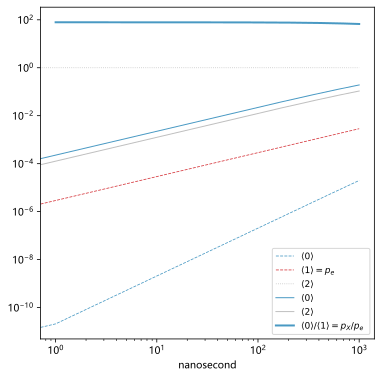

In [10]:
EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL)
tlist = np.linspace(0,int(1e3),1000)

fig, ax = plt.subplots(1,1,figsize = (6,6))

temp_in_mK = 20
alpha = 1

loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

result = qutip.mesolve(
    rho0=qutip.basis(qbt.truncated_dim, 2),
    H=qbt.diag_hamiltonian,
    tlist=tlist,
    c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude),
    e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(5)],
    args=None,
    options=qutip.Options(store_states=True, nsteps=1200000, num_cpus=1),
    progress_bar = qutip.ui.progressbar.EnhancedTextProgressBar(),
)
# Tphi_c_ops = qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude = one_over_f_flux_noise_amplitude)


ax.plot(tlist,result.expect[0],label=rf"$\langle{{0}}\rangle$",
        linestyle = '--',lw = 0.8,color='#4999c3',alpha=alpha)
ax.plot(tlist,result.expect[1],label=rf"$\langle{{1}}\rangle = p_e$",
        linestyle = '--',lw = 0.8,color='#d5373d',alpha=alpha)
ax.plot(tlist,result.expect[2],label=rf"$\langle{{2}}\rangle$",
        linestyle = ':',lw = 0.8,color='grey',alpha=0.5)

# ax.plot(tlist,result.expect[0]/result.expect[1],label=rf"$\langle{{0}}\rangle/\langle{{1}}\rangle = p_X/p_e$ ",
#         linestyle = '-',lw = 2,color='#4999c3',alpha=alpha)

# gamma_phi = np.abs(Tphi_c_ops.full().diagonal()[2])
# ax.plot(tlist,1-np.exp(-gamma_phi*tlist),label=rf"$p_\phi$",
#         linestyle = '--',lw = 0.8,color='#ff7f0e',alpha=alpha)
# ax.plot(tlist,(1-np.exp(-gamma_phi*tlist))/result.expect[1],label=rf"$ p_\phi/p_e$ ",
#         linestyle = '-',lw = 2,color='#ff7f0e',alpha=alpha)


result1 = qutip.mesolve(
    rho0=qutip.basis(qbt.truncated_dim, 3),
    H=qbt.diag_hamiltonian,
    tlist=tlist,
    c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude),
    e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(5)],
    args=None,
    options=qutip.Options(store_states=True, nsteps=1200000, num_cpus=1),
    progress_bar = qutip.ui.progressbar.EnhancedTextProgressBar(),
)
ax.plot(tlist,result1.expect[0],label=rf"$\langle{{0}}\rangle$",
        linestyle = '-',lw = 1,color='#4999c3',alpha=alpha)
# ax.plot(tlist,result1.expect[1],label=rf"$\langle{{1}}\rangle = p_e$",
#         linestyle = '-',lw =1,color='#d5373d',alpha=alpha)
ax.plot(tlist,result1.expect[2],label=rf"$\langle{{2}}\rangle$",
        linestyle = '-',lw = 1,color='grey',alpha=0.5)

ax.plot(tlist,result1.expect[0]/result.expect[1],label=rf"$\langle{{0}}\rangle/\langle{{1}}\rangle = p_X/p_e$ ",
        linestyle = '-',lw = 2,color='#4999c3',alpha=alpha)

ax.legend(loc='lower right',prop={'size': 9})
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e-6,2)
ax.set_xlabel(rf'nanosecond')

In [3]:
EJ = 4
EC = EJ / 2.7
EL = EJ / 45

qbt = gfIFQ(EJ=EJ, EC=EC, EL=EL, truncated_dim=20)
tlist = np.linspace(0, int(1e4), 1000)

temp_in_mK =20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(11)]


results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(qbt.truncated_dim, i) for i in range(3,10)],
    tlist = tlist,
    drive_terms = [],
    c_ops = c_ops,
    e_ops = e_ops
)

 /tmp/ipykernel_691541/2967192004.py: 38

 Total run time: 140.62s*] Elapsed 140.62s / Remaining 00:00:00:00[*********66%***        ] Elapsed 94.22s / Remaining 00:00:00:48
 Total run time: 143.42s*] Elapsed 143.42s / Remaining 00:00:00:00
 Total run time: 143.97s*] Elapsed 143.97s / Remaining 00:00:00:00
 Total run time: 144.02s*] Elapsed 144.02s / Remaining 00:00:00:00
 Total run time: 144.15s*] Elapsed 144.15s / Remaining 00:00:00:00
 Total run time: 145.97s*] Elapsed 145.97s / Remaining 00:00:00:00
 Total run time: 431.48s*] Elapsed 431.48s / Remaining 00:00:00:00


In [6]:
len(results)

7

# Most leakage states takes ~10 microsecod to decay

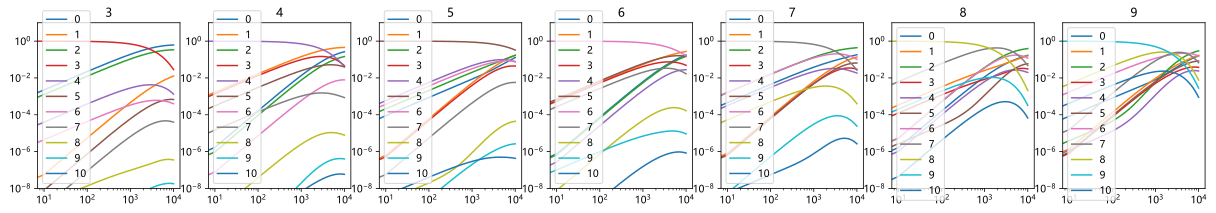

In [10]:
fig, axes = plt.subplots(1,7,figsize= (21,3))
for ql, (result, ax) in enumerate(zip(results,axes.flatten())):
    for i, exp in enumerate(result.expect):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_title(f"{ql+3}")
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e1)
    ax.set_xscale('log')